In [13]:
import numpy as np
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pywt
import os

In [14]:
current_dir = os.getcwd()
dataset_dir = os.path.join(current_dir, "medical_MRI_CT", "medical")
csv_profiling = "image_profiling_medical.csv"

In [21]:
data = []

for file in os.listdir(dataset_dir):
    if file.lower().endswith(".tif"):
        file_path = os.path.join(dataset_dir, file)

        try:
            with Image.open(file_path) as img:
                width, height = img.size
                aspect_ratio = round(width / height, 2) if height != 0 else None

                # Modality inference
                if "_1" in file:
                    modality = "CT"
                elif "_2" in file:
                    modality = "MRI"
                else:
                    modality = "Unknown"

                data.append({
                    "Filename": file,
                    "Format": img.format,
                    "Width": width,
                    "Height": height,
                    "Aspect_Ratio": aspect_ratio,
                    "Modality": modality
                })
        except Exception as e:
            print(f"Could not process {file}: {e}")

# Convert to DataFrame
df = pd.DataFrame(data)

In [25]:
df

,Filename,Format,Width,Height,Aspect_Ratio,Modality
0,c01_1.tif,TIFF,256,256,1.0,CT
1,c01_2.tif,TIFF,256,256,1.0,MRI
2,c02_1.tif,TIFF,256,256,1.0,CT
3,c02_2.tif,TIFF,256,256,1.0,MRI
4,c03_1.tif,TIFF,256,256,1.0,CT
5,c03_2.tif,TIFF,256,256,1.0,MRI
6,c04_1.tif,TIFF,256,256,1.0,CT
7,c04_2.tif,TIFF,256,256,1.0,MRI
8,c05_1.tif,TIFF,256,256,1.0,CT
9,c05_2.tif,TIFF,256,256,1.0,MRI


In [31]:
def plot_dataset_overview_row(df):
    """Plots all dataset checks in a single row (4 subplots)."""
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # 1. Modality Distribution
    df['Modality'].value_counts().plot(kind='bar', ax=axes[0])
    axes[0].set_title("Modality Distribution")
    axes[0].set_xlabel("Modality")
    axes[0].set_ylabel("Count")

    # 2. Image Dimensions (Width vs Height)
    axes[1].scatter(df['Width'], df['Height'])
    axes[1].set_title("Width vs Height")
    axes[1].set_xlabel("Width")
    axes[1].set_ylabel("Height")
    axes[1].grid(True)

    # 3. Aspect Ratio Distribution
    df['Aspect_Ratio'].plot(kind='hist', bins=10, ax=axes[2])
    axes[2].set_title("Aspect Ratio Distribution")
    axes[2].set_xlabel("Aspect Ratio")
    axes[2].set_ylabel("Frequency")

    # 4. Modality Count per Case
    df['Case'] = df['Filename'].str.extract(r'(c\d+)_')
    case_counts = df.groupby(['Case', 'Modality']).size().unstack(fill_value=0)
    case_counts.plot(kind='bar', stacked=True, ax=axes[3])
    axes[3].set_title("Modality Count per Case")
    axes[3].set_xlabel("Case")
    axes[3].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

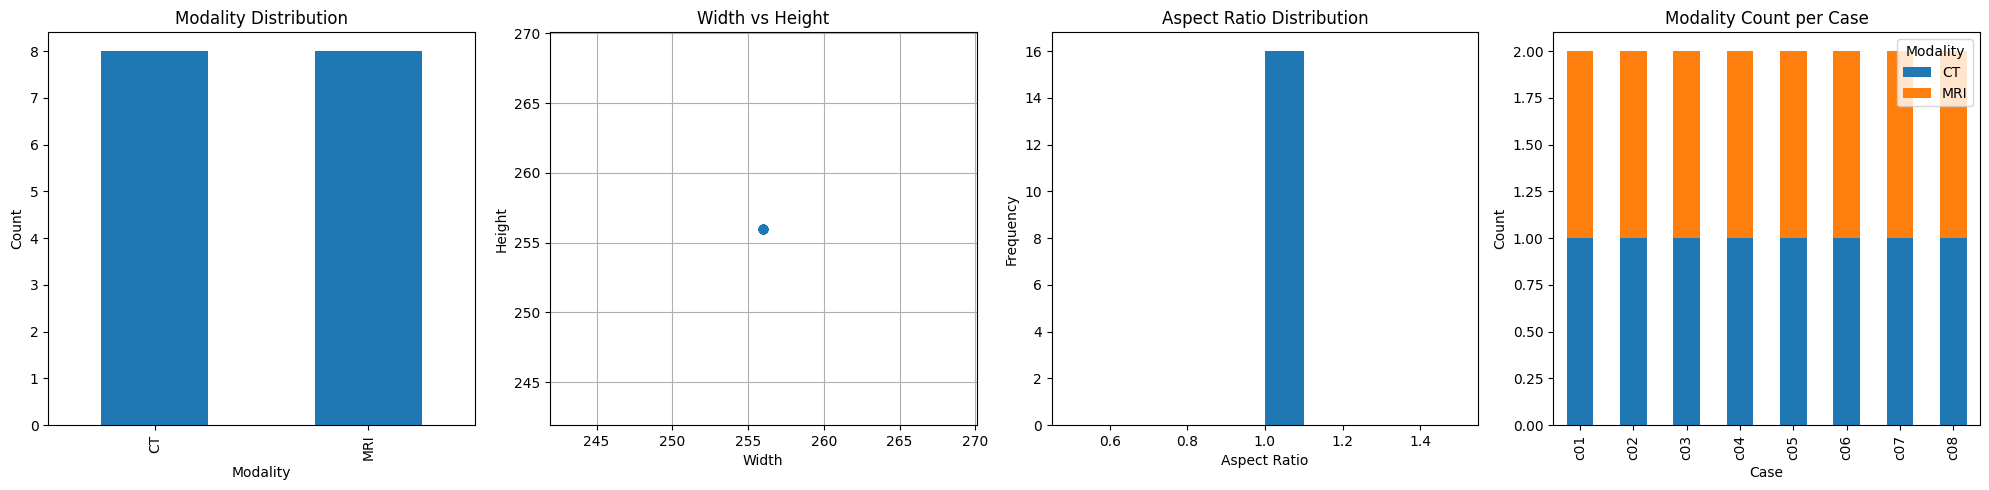

In [33]:
plot_dataset_overview_row(df)

In [59]:
def build_gaussian_pyramid(img, levels=4):
    gp = [img.copy()]
    for _ in range(levels):
        img = cv2.pyrDown(img)
        gp.append(img)
    return gp

def build_laplacian_pyramid(gp):
    lp = [gp[-1]]
    for i in range(len(gp)-1, 0, -1):
        size = (gp[i-1].shape[1], gp[i-1].shape[0])
        GE = cv2.pyrUp(gp[i], dstsize=size)
        L = cv2.subtract(gp[i-1], GE)
        lp.append(L)
    return lp[::-1]

def fuse_average(lp1, lp2):
    return [cv2.addWeighted(l1, 0.5, l2, 0.5, 0) for l1, l2 in zip(lp1, lp2)]

def fuse_max(lp1, lp2):
    return [np.maximum(l1, l2) for l1, l2 in zip(lp1, lp2)]

def fuse_pca(lp1, lp2):
    fused = []
    for l1, l2 in zip(lp1, lp2):
        a = l1.flatten().astype(np.float32)
        b = l2.flatten().astype(np.float32)
        
        data = np.vstack((a, b))
        
        # Subtract mean
        mean = np.mean(data, axis=1, keepdims=True)
        data_centered = data - mean
        
        # Covariance matrix
        cov = np.cov(data_centered)
        
        # Eigen decomposition
        eigvals, eigvecs = np.linalg.eig(cov)
        principal = eigvecs[:, np.argmax(eigvals)]
        
        # Normalize weights
        w = principal / np.sum(principal)
        
        # Fuse
        fused_level = w[0] * l1 + w[1] * l2
        fused.append(fused_level.astype(np.float32))
    
    return fused


def fuse_max_abs(lp1, lp2):
    return [np.where(np.abs(l1) > np.abs(l2), l1, l2) for l1, l2 in zip(lp1, lp2)]

def fuse_energy_max(lp1, lp2, window=3):
    fused = []
    for l1, l2 in zip(lp1, lp2):
        e1 = cv2.blur(l1.astype(np.float32)**2, (window, window))
        e2 = cv2.blur(l2.astype(np.float32)**2, (window, window))
        fused.append(np.where(e1 > e2, l1, l2))
    return fused

def reconstruct_from_pyramid(pyramid):
    img = pyramid[-1]
    for i in range(len(pyramid)-2, -1, -1):
        size = (pyramid[i].shape[1], pyramid[i].shape[0])
        img = cv2.pyrUp(img, dstsize=size)
        img = cv2.add(img, pyramid[i])
    return img

def run_fusion_pipeline(ct, mri, levels=4):
    ct_gp = build_gaussian_pyramid(ct, levels)
    mri_gp = build_gaussian_pyramid(mri, levels)
    ct_lp = build_laplacian_pyramid(ct_gp)
    mri_lp = build_laplacian_pyramid(mri_gp)
    return {
        'Average': reconstruct_from_pyramid(fuse_average(ct_lp, mri_lp)),
        'Max': reconstruct_from_pyramid(fuse_max(ct_lp, mri_lp)),
        'pca': reconstruct_from_pyramid(fuse_pca(ct_lp, mri_lp)),
        'Max-Abs': reconstruct_from_pyramid(fuse_max_abs(ct_lp, mri_lp)),
        'Energy-Max': reconstruct_from_pyramid(fuse_energy_max(ct_lp, mri_lp))
    }

def plot_fused_results(results_dict, ct, mri):
    n = len(results_dict) + 2
    plt.figure(figsize=(16, 4))
    plt.subplot(1, n, 1); plt.imshow(ct, cmap='gray'); plt.title("CT"); plt.axis('off')
    plt.subplot(1, n, 2); plt.imshow(mri, cmap='gray'); plt.title("MRI"); plt.axis('off')
    for i, (name, img) in enumerate(results_dict.items(), start=3):
        plt.subplot(1, n, i)
        plt.imshow(np.clip(img, 0, 255).astype(np.uint8), cmap='gray')
        plt.title(name); plt.axis('off')
    plt.tight_layout()
    plt.show()

In [212]:
ct_dir = os.path.join(dataset_dir, "c03_1.tif")
mri_dir = os.path.join(dataset_dir, "c03_2.tif")

ct = cv2.imread(ct_dir, cv2.IMREAD_GRAYSCALE)
mri = cv2.imread(mri_dir, cv2.IMREAD_GRAYSCALE)

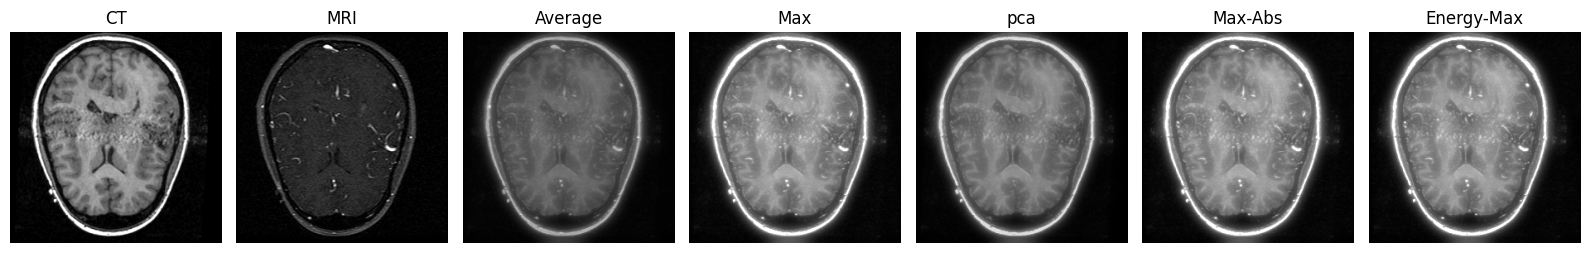

In [214]:
results = run_fusion_pipeline(ct, mri, levels=3)
plot_fused_results(results, ct, mri)

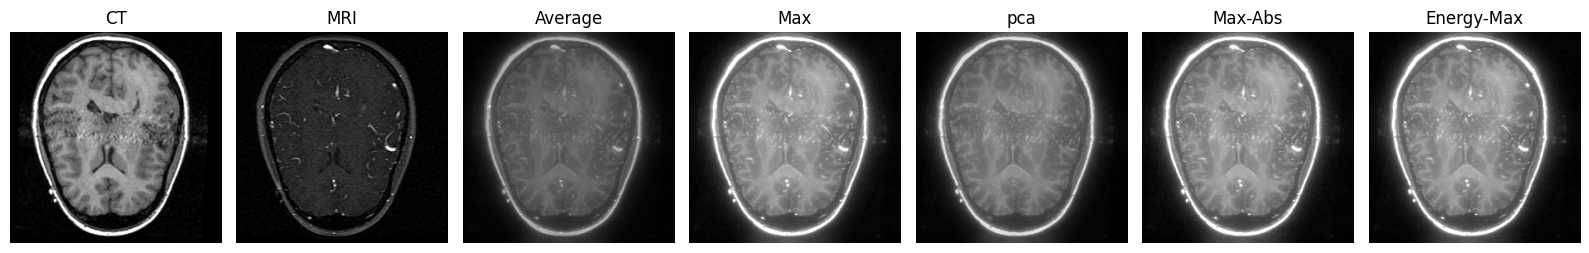

In [215]:
results = run_fusion_pipeline(ct, mri, levels=4)
plot_fused_results(results, ct, mri)

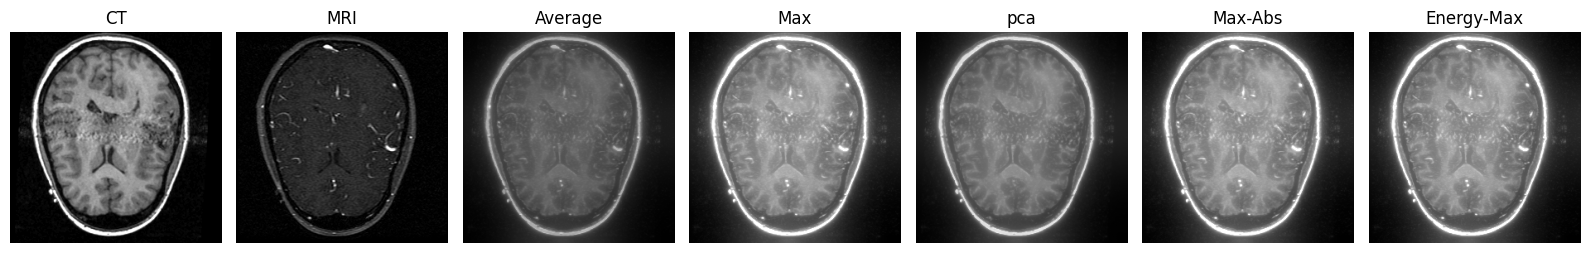

In [216]:
results = run_fusion_pipeline(ct, mri, levels=5)
plot_fused_results(results, ct, mri)

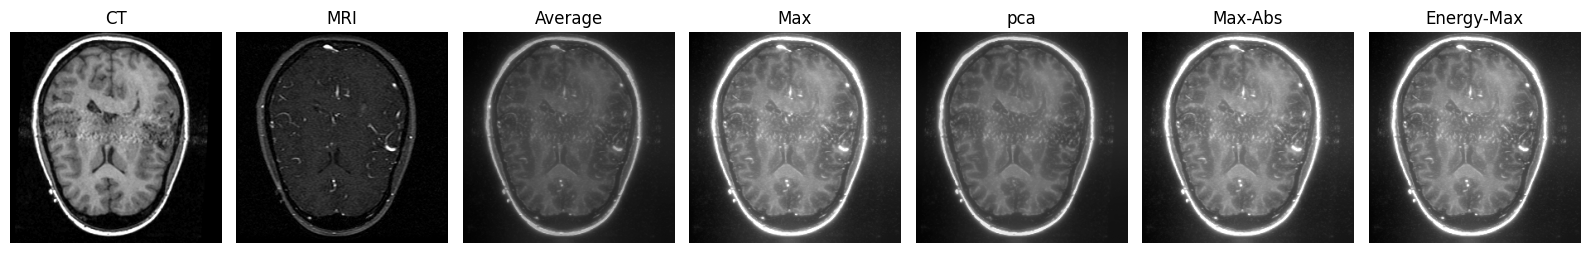

In [218]:
results = run_fusion_pipeline(ct, mri, levels=6)
plot_fused_results(results, ct, mri)

In [201]:
def build_wavelet_pyramid(img, wavelet='db4', levels=3):
    """
    Decompose image into wavelet pyramid (MST).
    """
    coeffs = pywt.wavedec2(img.astype(np.float32), wavelet=wavelet, level=levels)
    return coeffs

def fuse_wavelet_pyramids(wp1, wp2, method='average', energy_window=3):
    """
    Fuse wavelet pyramids with advanced methods.
    """
    fused = []

    # --- Approximation Coefficients (LL) ---
    if method == 'average':
        fused_approx = (wp1[0] + wp2[0]) / 2
    elif method == 'max':
        fused_approx = np.maximum(wp1[0], wp2[0])
    elif method == 'min':
        fused_approx = np.minimum(wp1[0], wp2[0])
    elif method == 'weighted':
        fused_approx = 0.6 * wp1[0] + 0.4 * wp2[0]
    else:
        fused_approx = (wp1[0] + wp2[0]) / 2  # fallback
    fused.append(fused_approx)

    # --- Detail Coefficients (LH, HL, HH) ---
    for i in range(1, len(wp1)):
        c1, c2 = wp1[i], wp2[i]
        fused_details = []

        for j in range(3):  # LH, HL, HH
            d1, d2 = c1[j], c2[j]

            if method == 'average':
                fused_detail = (d1 + d2) / 2

            elif method == 'max':
                fused_detail = np.maximum(d1, d2)

            elif method == 'min':
                fused_detail = np.minimum(d1, d2)

            elif method == 'max_abs':
                fused_detail = np.where(np.abs(d1) > np.abs(d2), d1, d2)

            elif method == 'energy_max':
                e1 = cv2.blur(d1**2, (energy_window, energy_window))
                e2 = cv2.blur(d2**2, (energy_window, energy_window))
                fused_detail = np.where(e1 > e2, d1, d2)

            elif method == 'pca':
                # Flatten, stack
                vec1 = d1.flatten().astype(np.float32)
                vec2 = d2.flatten().astype(np.float32)
                data = np.vstack((vec1, vec2))
                mean = np.mean(data, axis=1, keepdims=True)
                centered = data - mean
                cov = np.cov(centered)
                eigvals, eigvecs = np.linalg.eig(cov)
                w = eigvecs[:, np.argmax(eigvals)]
                w /= np.sum(w)
                fused_detail = w[0] * d1 + w[1] * d2

            else:
                # fallback
                fused_detail = (d1 + d2) / 2

            fused_details.append(fused_detail)

        fused.append(tuple(fused_details))

    return fused

def reconstruct_wavelet_pyramid(fused_wp, wavelet='db4'):
    """
    Reconstruct image from fused wavelet pyramid (IMST).
    """
    image = pywt.waverec2(fused_wp, wavelet)
    return np.clip(image, 0, 255).astype(np.uint8)

def run_wavelet_fusion_pipeline(ct, mri, wavelet='db4', levels=3):
    """
    Run wavelet-based fusion using multiple methods.
    
    Returns:
        A dictionary of fused images using various fusion strategies.
    """
    ct_wp = build_wavelet_pyramid(ct, wavelet, levels)
    mri_wp = build_wavelet_pyramid(mri, wavelet, levels)

    results = {}
    fusion_methods = [
        'average',
        'max',
        'min',
        'weighted',
        'max_abs',
        'energy_max',
        'pca'
    ]

    for method in fusion_methods:
        fused_wp = fuse_wavelet_pyramids(ct_wp, mri_wp, method)
        fused_img = reconstruct_wavelet_pyramid(fused_wp, wavelet)
        results[method.replace("_", " ").title()] = fused_img

    return results


def plot_fused_wavelet_results(results_dict, ct, mri):
    n = len(results_dict) + 2
    plt.figure(figsize=(16, 4))
    plt.subplot(1, n, 1); plt.imshow(ct, cmap='gray'); plt.title("CT"); plt.axis('off')
    plt.subplot(1, n, 2); plt.imshow(mri, cmap='gray'); plt.title("MRI"); plt.axis('off')
    for i, (name, img) in enumerate(results_dict.items(), start=3):
        plt.subplot(1, n, i)
        plt.imshow(img, cmap='gray')
        plt.title(name); plt.axis('off')
    plt.tight_layout()
    plt.show()

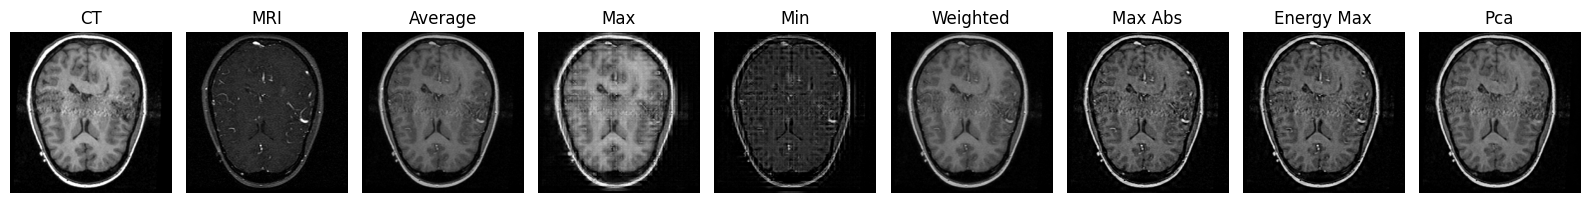

In [222]:
results = run_wavelet_fusion_pipeline(ct, mri)
plot_fused_wavelet_results(results, ct, mri)

### tuning the wavelet code methods

In [206]:
import random
from collections import defaultdict

def random_search_wavelet_fusion(
    ct, mri,
    wavelet_pool=None,
    level_range=(1, 5),
    n_trials=10,
    seed=42
):
    """
    Run random search over wavelet types and decomposition levels.
    For each sampled combination, apply all fusion methods.
    
    Returns:
        Dictionary of structure:
        {
            (wavelet, level): {
                'Average': fused_image,
                'Max': fused_image,
                ...
            },
            ...
        }
    """
    import pywt

    if wavelet_pool is None:
        wavelet_pool = pywt.wavelist(kind='discrete')  # All discrete wavelets

    random.seed(seed)
    search_space = [(w, l) for w in wavelet_pool for l in range(level_range[0], level_range[1] + 1)]
    sampled_configs = random.sample(search_space, min(n_trials, len(search_space)))

    results = {}

    for wavelet, level in sampled_configs:
        try:
            print(f"🔍 Trying Wavelet: {wavelet}, Levels: {level}")
            fused_images = run_wavelet_fusion_pipeline(ct, mri, wavelet=wavelet, levels=level)
            results[(wavelet, level)] = fused_images
        except Exception as e:
            print(f"⚠️ Failed at {wavelet} - Level {level}: {e}")
    
    return results

def show_all_fusion_results_for_each_config(results, ct, mri):
    """
    Iterates through all (wavelet, level) configs and uses the user's existing
    plot_fused_wavelet_results function to show all fusion results side by side.
    """
    for (wavelet, level), fused_results in results.items():
        print(f"Showing results for Wavelet: {wavelet}, Level: {level}")
        plot_fused_wavelet_results(fused_results, ct, mri)

🔍 Trying Wavelet: coif8, Levels: 5
🔍 Trying Wavelet: bior2.6, Levels: 1
🔍 Trying Wavelet: db25, Levels: 2
🔍 Trying Wavelet: db19, Levels: 1
🔍 Trying Wavelet: db14, Levels: 4
Showing results for Wavelet: coif8, Level: 5


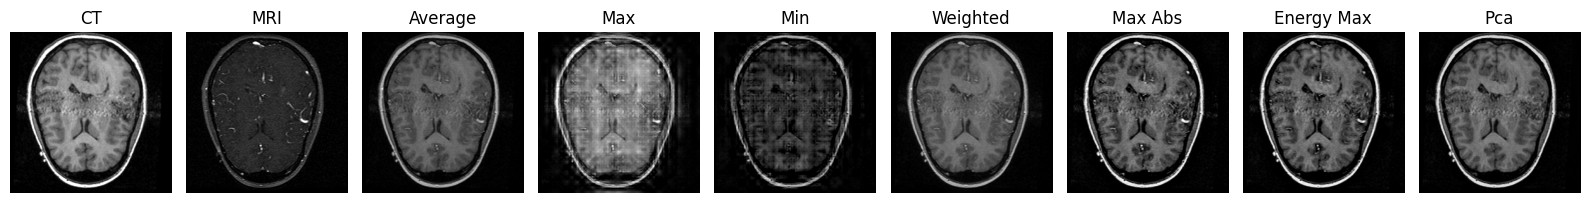

Showing results for Wavelet: bior2.6, Level: 1


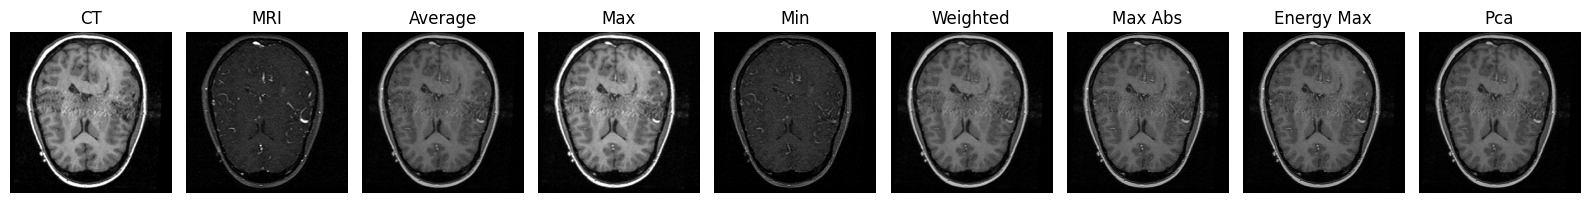

Showing results for Wavelet: db25, Level: 2


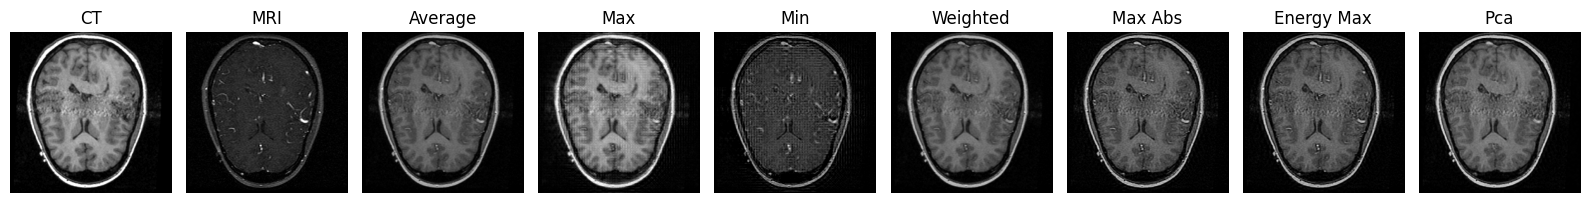

Showing results for Wavelet: db19, Level: 1


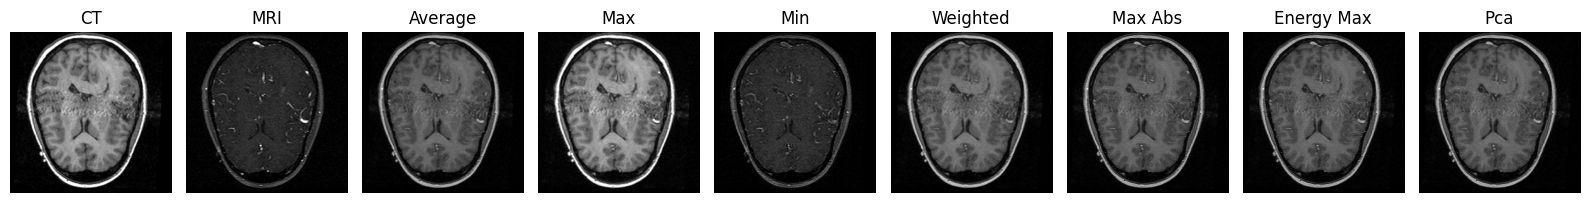

Showing results for Wavelet: db14, Level: 4


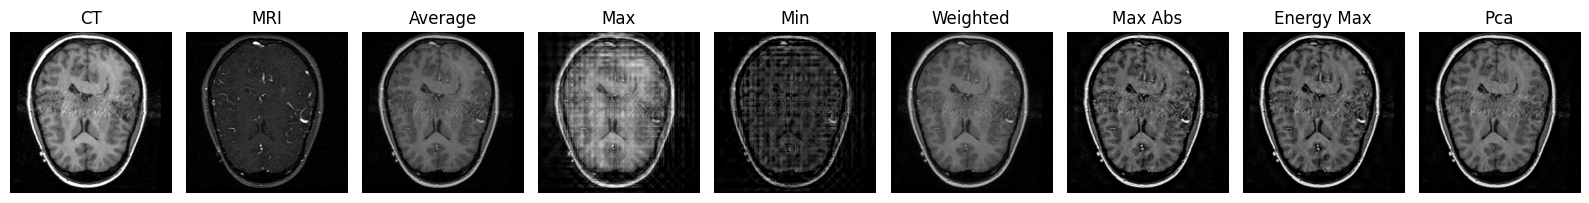

In [224]:
results = random_search_wavelet_fusion(ct, mri, n_trials=5)
show_all_fusion_results_for_each_config(results, ct, mri)

### DL methods:
below is a method of deeplearning, based on this article: `https://github.com/HeDan-11/DM-FNet/`

I have tried to run inference from this model, but as the arcitucture was too heavy, I avoided that. I have placed my understandings from this, inside my documentations, please consider reading that.
I will just provide the main arcitucture as following:

In [ ]:
class DDPM(BaseModel):
    def __init__(self, opt):
        super(DDPM, self).__init__(opt)
        # define network and load pretrained models
        self.netG = self.set_device(networks.define_G(opt))
        self.schedule_phase = None
        # set loss and load resume state
        self.set_loss()
        self.set_new_noise_schedule(
            opt['model']['beta_schedule']['train'], schedule_phase='train')
        if self.opt['phase'] == 'train':
            self.netG.train()
            # find the parameters to optimize
            if opt['model']['finetune_norm']:
                optim_params = []
                for k, v in self.netG.named_parameters():
                    v.requires_grad = False
                    if k.find('transformer') >= 0:
                        v.requires_grad = True
                        v.data.zero_()
                        optim_params.append(v)
                        logger.info(
                            'Params [{:s}] initialized to 0 and will optimize.'.format(k))
            else:
                optim_params = list(self.netG.parameters())

            if opt['train']["optimizer"]["type"] == "adam":
                self.optG = torch.optim.Adam(
                    optim_params, lr=opt['train']["optimizer"]["lr"])
            elif opt['train']["optimizer"]["type"] == "adamw":
                self.optG = torch.optim.AdamW(
                    optim_params, lr=opt['train']["optimizer"]["lr"])
            else:
                raise NotImplementedError(
                    'Optimizer [{:s}] not implemented'.format(opt['train']["optimizer"]["type"]))

            self.log_dict = OrderedDict()
        else:
            optim_params = list(self.netG.parameters())
        self.load_network()
        self.print_network()
        self.loss_all = []

    def feed_data(self, data):
        self.data = self.set_device(data)

class DFFM(BaseModel):
    def __init__(self, opt):
        super(DFFM, self).__init__(opt)
        # define network and load pretrained models
        self.netDF = self.set_device(networks.define_DFFM(opt))

        # set loss and load resume state
        if self.opt['model_df']['out_channels'] == 1:
            self.loss_func = Fusionloss().to(self.device)
        if self.opt['phase'] == 'train':
            self.netDF.train()
            # find the parameters to optimize
            optim_df_params = list(self.netDF.parameters())

            if opt['train']["optimizer"]["type"] == "adam":
                self.optDF = torch.optim.Adam(
                    optim_df_params, lr=opt['train']["optimizer"]["lr"])
            elif opt['train']["optimizer"]["type"] == "adamw":
                self.optDF = torch.optim.AdamW(
                    optim_df_params, lr=opt['train']["optimizer"]["lr"])
            else:
                raise NotImplementedError(
                    'Optimizer [{:s}] not implemented'.format(opt['train']["optimizer"]["type"]))
            self.log_dict = OrderedDict()

            # Define learning rate sheduler
            self.exp_lr_scheduler_netDF = get_scheduler(optimizer=self.optDF, args=opt['train'])
        else:
            self.netDF.eval()
            optim_df_params = list(self.netDF.parameters())

            self.log_dict = OrderedDict()

        self.load_network()
        self.print_network()
        self.loss_all = []
        self.loss_in = []
        self.loss_grad = []
        self.len_train_dataloader = opt["len_train_dataloader"]
        self.len_val_dataloader = opt["len_val_dataloader"]
        self.alpha = 1.0

    # Feeding all data to the DF model
    def feed_data(self, feats, data):
        self.feats = feats
        self.data = self.set_device(data)